### Import of required libraries

In [1]:
from traffic.core import Traffic
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import functions as fn


### Preparation of data on trajectory level

In [2]:
# Load data, assign unique flight IDs, resample to 5s
trajs = Traffic.from_file('data/rectangle_1//combined/combined.parquet')
trajs_filt = trajs.assign_id().resample('5s').eval(desc='processing', max_workers=20)
# Aggregate by flight, determine stay time and hour of entry
df = trajs_filt.data
df = df.groupby('flight_id')['timestamp'].agg(['min', 'max']).reset_index()
df = df.rename({'min': 'in', 'max': 'out'}, axis=1)
df['stay_s'] = (df['out'] - df['in']).dt.total_seconds()
df['timestamp_entered_h'] = df['in'].dt.floor('h')
df = df.drop(['in','out'], axis=1)
df


Output()

,flight_id,stay_s,timestamp_entered_h
0,00000000_6162,55.0,2020-02-18 13:00:00+00:00
1,20_062,5.0,2021-09-24 12:00:00+00:00
2,2AUER_9068,120.0,2019-08-25 09:00:00+00:00
3,2BILL_9100,115.0,2022-05-16 06:00:00+00:00
4,2COOK_9075,150.0,2020-09-16 08:00:00+00:00
...,...,...,...
64018,YUTUU_52140,90.0,2022-07-13 08:00:00+00:00
64019,YUTUU_52141,105.0,2022-08-17 06:00:00+00:00
64020,YUTUU_52142,80.0,2022-09-30 06:00:00+00:00
64021,YUTUU_52143,30.0,2022-11-14 17:00:00+00:00


### Group data by hour

In [3]:
# Aggregate by hour of entry, determine number of users and total stay time
hourly_stay = df.groupby(['timestamp_entered_h'])['stay_s'].sum()
hourly_users = df.groupby(['timestamp_entered_h'])['flight_id'].count()
hourly_df = pd.concat([hourly_users, hourly_stay], axis=1)#.reset_index()
hourly_df = hourly_df.rename({'flight_id': 'count'}, axis=1)
hourly_df


,count,stay_s
timestamp_entered_h,,
2019-01-01 07:00:00+00:00,1,40.0
2019-01-01 08:00:00+00:00,3,175.0
2019-01-01 09:00:00+00:00,6,355.0
2019-01-01 11:00:00+00:00,3,115.0
2019-01-01 12:00:00+00:00,5,260.0
...,...,...
2022-12-30 17:00:00+00:00,2,125.0
2022-12-30 18:00:00+00:00,2,50.0
2022-12-30 20:00:00+00:00,2,115.0


### Visualisation of data grouped by hour, day, week and month

<Axes: xlabel='timestamp_entered_h'>

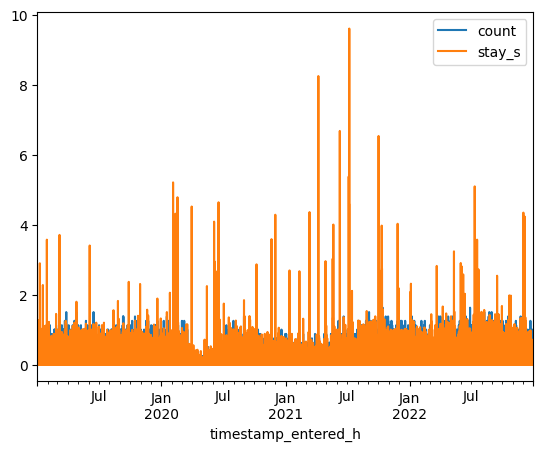

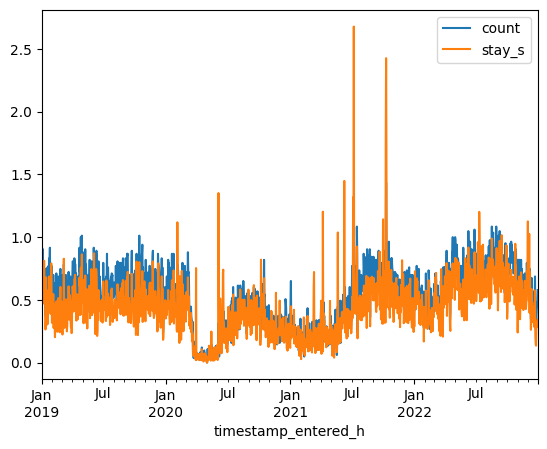

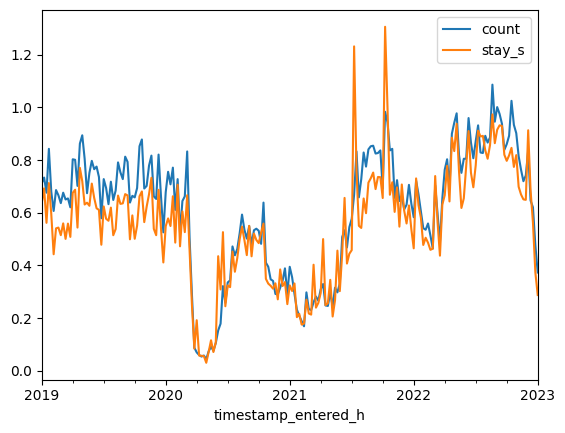

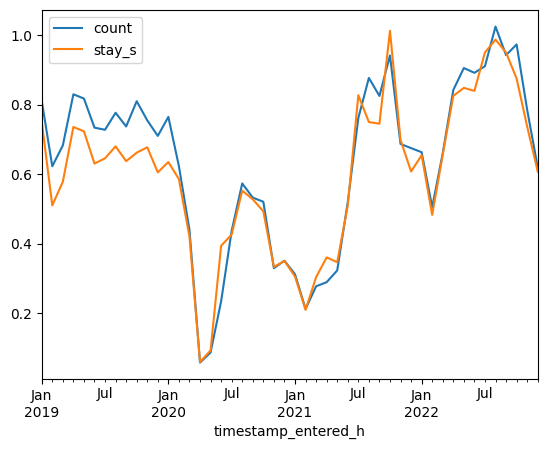

In [4]:
# Hour
hourly_group = hourly_df.groupby(pd.Grouper(freq='h')).sum()
hourly_group = hourly_group/hourly_group.quantile(0.99)
hourly_group.plot()

# Day
daily_group = hourly_df.groupby(pd.Grouper(freq='D')).sum()
daily_group = daily_group/daily_group.quantile(0.99)
daily_group.plot()
dayer = daily_group.groupby(daily_group.index.dayofweek).stay_s.mean()

# Week
daily_group = hourly_df.groupby(pd.Grouper(freq='w')).sum()
daily_group = daily_group/daily_group.quantile(0.99)
daily_group.plot()

# Month
daily_group = hourly_df.groupby(pd.Grouper(freq='m')).sum()
daily_group = daily_group/daily_group.quantile(0.99)
daily_group.plot()


### Plot of "Traffic-seconds" per hour on a timeline

(0.0, 1132.5)

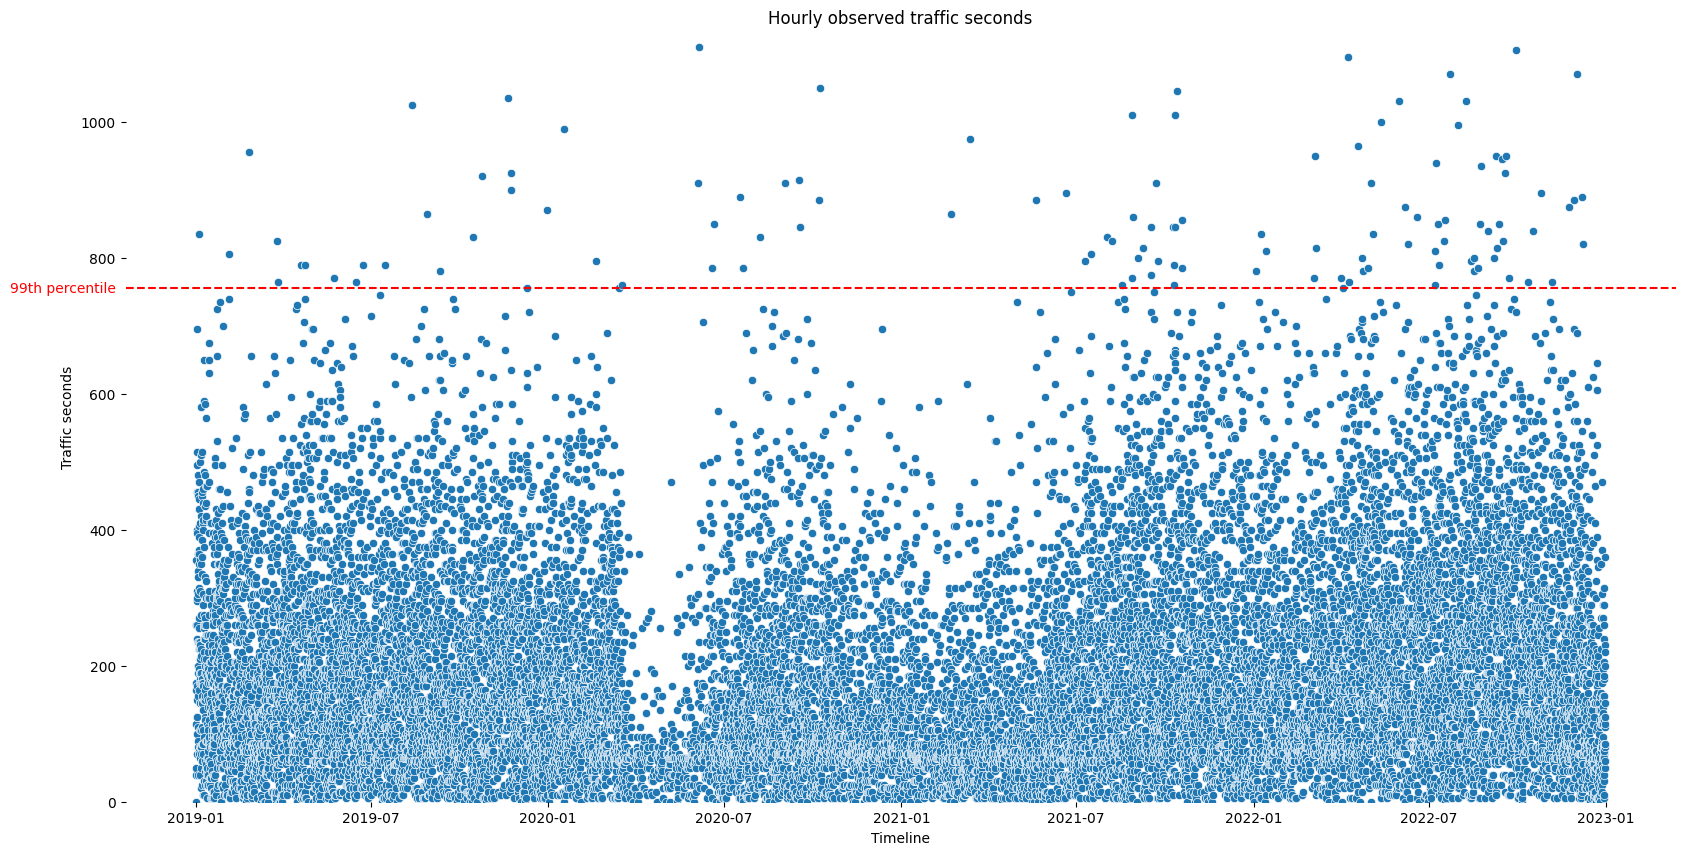

In [5]:
# Group by hour
# hourly_group = hourly_df.groupby(pd.Grouper(freq='h')).sum()

# Plot traffic seconds per hour on a timeline
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="timestamp_entered_h", y="stay_s", data=hourly_df, ax=ax)

# draw 99th percentile
ax.axhline(y=hourly_df.quantile(0.99).stay_s, color='r', linestyle='--')
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, hourly_df.quantile(0.99).stay_s, ('99th percentile'),
        color="red", transform=trans, ha="right", va="center")

# proper axes and labels
ax.set_ylabel('Traffic seconds')
ax.set_xlabel('Timeline')
ax.set_title('Hourly observed traffic seconds')
ax.set_ylim(0, hourly_df.quantile(0.99).stay_s*1.5)


### Define max hourly traffic and express every hour as a fraction of the max

(-0.01, 1.5)

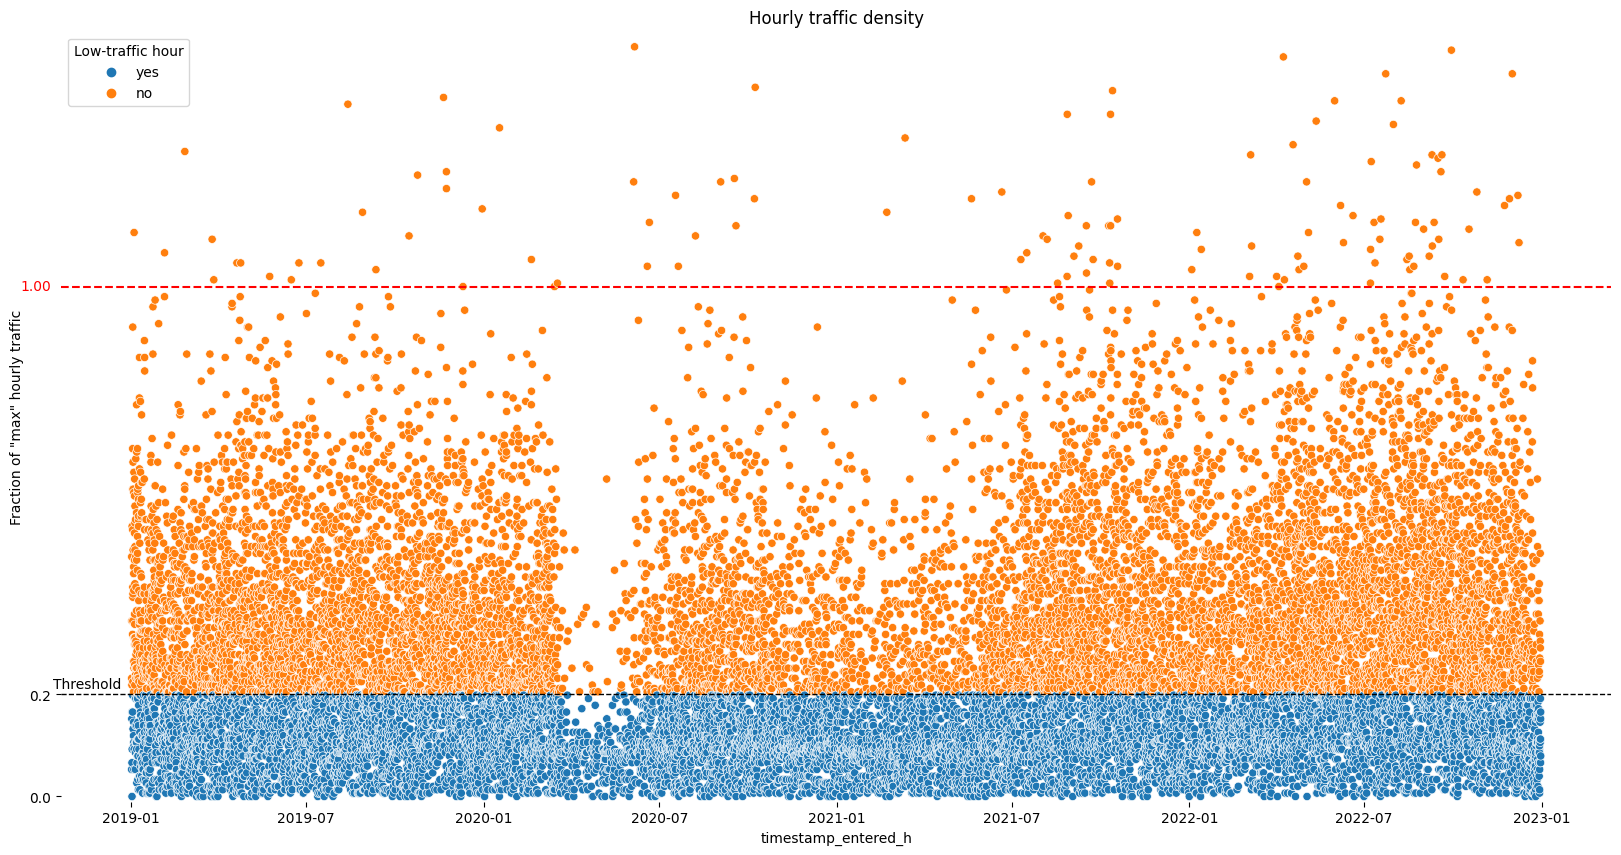

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Express traffic seconds as a fraction of the 99th percentile
# hourly_group = hourly_df.groupby(pd.Grouper(freq='h')).sum()
hourly_df = hourly_df/hourly_df.quantile(0.99)

# Add a column to the dataframe that indicates whether the hour is low traffic
# (< 20% of 99th percentile)
hourly_df['low'] = hourly_df['stay_s'].apply(lambda x: 'yes' if x < 0.2 and x >= 0 else 'no')

# Plot traffic seconds per hour on a timeline, color by low traffic
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="timestamp_entered_h", y="stay_s",
                hue="low", 
                data=hourly_df, ax=ax)
# Draw a line for the reference and the threshold
ax.axhline(y=0.2, color='black', linestyle='--', linewidth=1)
ax.axhline(y=1, color='r', linestyle='--')
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, 1, '1.00',
        color="red", transform=trans, ha="right", va="center")
ax.text(0.045, 0.22, ('Threshold'),
        color="black", transform=trans, ha="right", va="center")

# Make it look nice
ax.set_ylabel('Fraction of "max" hourly traffic')
ax.legend(title='Low-traffic hour')
ax.set_yticks([0, 0.2, 2, 3, 4])
ax.set_title('Hourly traffic density')
ax.set_ylim(-0.01, hourly_df.quantile(0.99).stay_s*1.5)


### Plot distribution of low traffic hours over the day

##### With empty hours

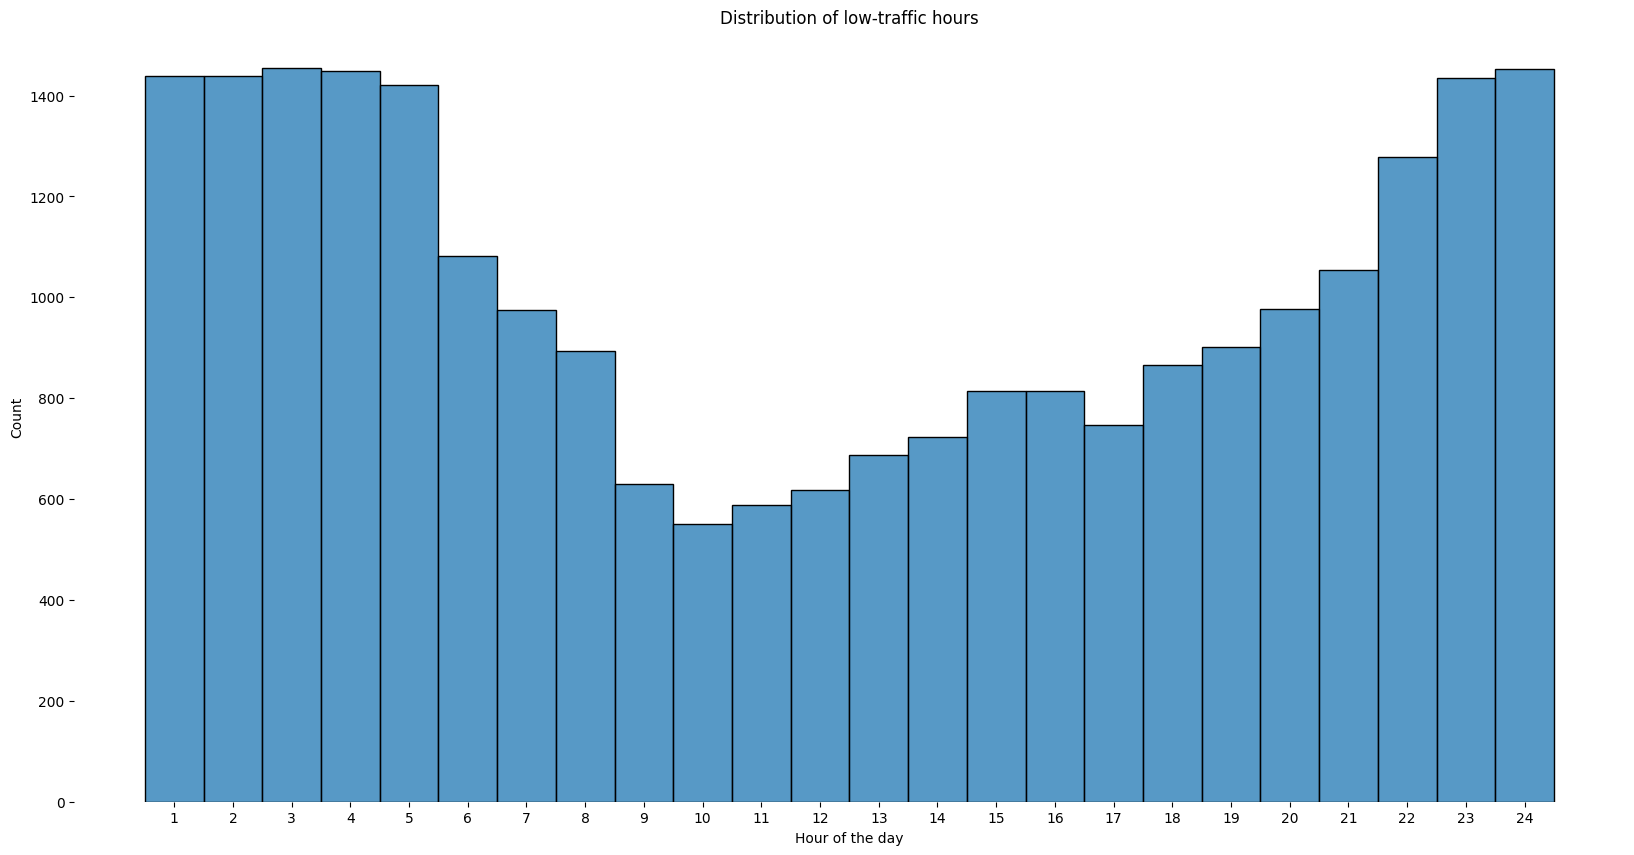

In [12]:
# Extract hours that are low traffic, transform to hour of the day
hourly_group = hourly_df.groupby(pd.Grouper(freq='h')).sum() # to add empty hours
hourly_group = hourly_group[hourly_group.stay_s < 0.2]
hours_low = hourly_group.index.hour
hours_low += 1
# plot histogram
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.histplot(hours_low, ax=ax, bins=23, discrete=True)
ax.set_title('Distribution of low-traffic hours')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Count')
ax.set_xticks(range(1,25))


##### Without empty hours

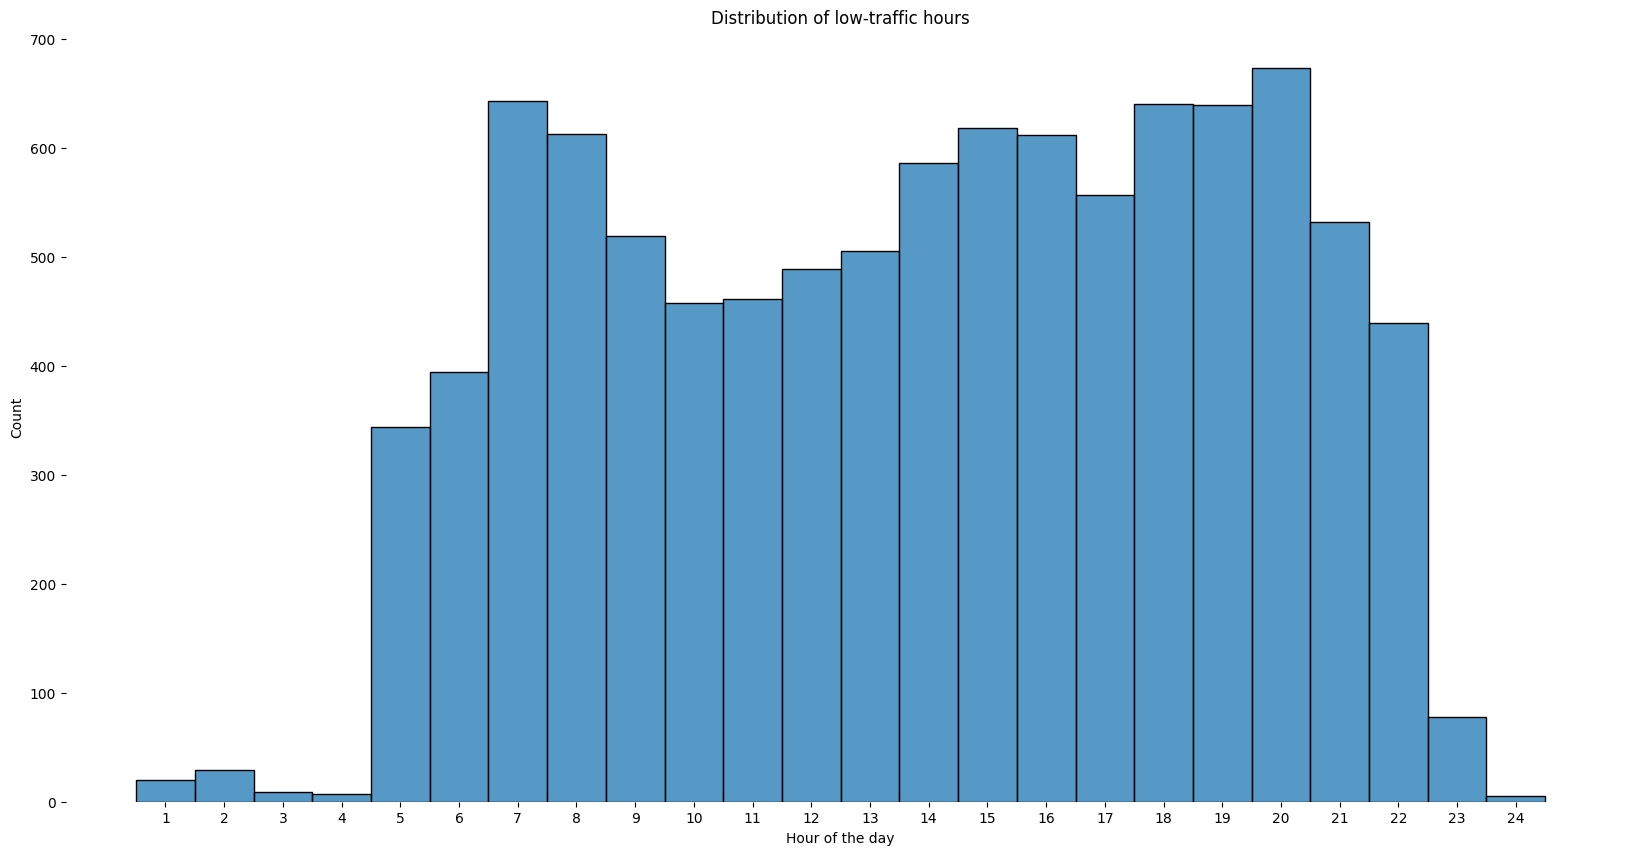

In [13]:
# Extract hours that are low traffic, transform to hour of the day
hours_low = hourly_df[hourly_df.low == 'yes'].index.hour
hours_low += 1
# plot histogram
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.histplot(hours_low, ax=ax, bins=23, discrete=True)
ax.set_title('Distribution of low-traffic hours')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Count')
ax.set_xticks(range(1,25))


In [14]:
low_hours = hourly_df[hourly_df.low == 'yes'].index
ids_use = df[df.timestamp_entered_h.isin(low_hours)].flight_id.to_numpy()
trajs_filt = trajs_filt[ids_use]
trajs_filt

,count
flight_id,
E10E2_63860,31
ABR177_53842,31
ENT6052_18329,31
N965AP_63699,31
ABR7CK_53762,31
CTN461_57706,31
JSH521_17647,31
NAF31_18049,31
ABR177_53833,31


In [15]:
trajs_func = fn.get_lowtraf_trajs(trajs)
trajs_func


Output()

,count
flight_id,
E10E2_63860,31
ABR177_53842,31
ENT6052_18329,31
N965AP_63699,31
ABR7CK_53762,31
CTN461_57706,31
JSH521_17647,31
NAF31_18049,31
ABR177_53833,31
